In [ ]:
%whos

Interactive namespace is empty.


In [ ]:
!pip install -q yfinance transformers torch ta tqdm scikit-learn seaborn pandas numpy matplotlib

  Preparing metadata (setup.py) ... done


In [ ]:
#!pip install pytorch-lightning pytorch-forecasting --quiet
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 22.1 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
import ta
import re
import torch
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import lightgbm as lgb
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn-v0_8")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd

NEWS_PATH = "/content/drive/MyDrive/Feature_Engineering/raw_partner_headlines.csv"

news_df = pd.read_csv(NEWS_PATH)

print("Loaded news shape:", news_df.shape)
news_df.head()

Loaded news shape: (1845559, 6)


,Unnamed: 0,headline,url,publisher,date,stock
0,2,Agilent Technologies Announces Pricing of $5……...,http://www.gurufocus.com/news/1153187/agilent-...,GuruFocus,2020-06-01 00:00:00,A
1,3,Agilent (A) Gears Up for Q2 Earnings: What's i...,http://www.zacks.com/stock/news/931205/agilent...,Zacks,2020-05-18 00:00:00,A
2,4,J.P. Morgan Asset Management Announces Liquida...,http://www.gurufocus.com/news/1138923/jp-morga...,GuruFocus,2020-05-15 00:00:00,A
3,5,"Pershing Square Capital Management, L.P. Buys ...",http://www.gurufocus.com/news/1138704/pershing...,GuruFocus,2020-05-15 00:00:00,A
4,6,Agilent Awards Trilogy Sciences with a Golden ...,http://www.gurufocus.com/news/1134012/agilent-...,GuruFocus,2020-05-12 00:00:00,A


In [ ]:
news_df = news_df.rename(columns={
    "date": "date",
    "stock": "ticker",
    "headline": "headline",
})

news_df = news_df[["date", "ticker", "headline"]].dropna()
news_df["date"] = pd.to_datetime(news_df["date"])
news_df = news_df.sort_values(["ticker", "date"]).reset_index(drop=True)

Filter Top Tickers and substitute with YFiance data id needed

In [ ]:
top_tickers = news_df['ticker'].value_counts().head(25).index.tolist()
news_df = news_df[news_df['ticker'].isin(top_tickers)]

print("Top tickers:", top_tickers)

Top tickers: ['KR', 'GXC', 'PGJ', 'YINN', 'JPM', 'FXP', 'XPP', 'FCAU', 'CHN', 'JWN', 'ERO', 'RSP', 'OXY', 'DISH', 'BLK', 'VGK', 'MDT', 'UGAZ', 'KEY', 'AVGO', 'TJX', 'VNQ', 'INTC', 'MYL', 'DGAZ']


In [ ]:
# Filter valid tickers
def ticker_valid(t):
    try:
        hist = yf.Ticker(t).history(period="5d")
        return not hist.empty
    except:
        return False

valid_tickers = [t for t in top_tickers if ticker_valid(t)]

print("Valid tickers:", valid_tickers)

ERROR:yfinance:$FCAU: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$CHN: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:$JWN: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$DISH: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$UGAZ: possibly delisted; no price data found  (period=5d)
ERROR:yfinance:$MYL: possibly delisted; no price data found  (period=5d) (Yahoo error = "No data found, symbol may be delisted")
ERROR:yfinance:$DGAZ: possibly delisted; no price data found  (period=5d)


Valid tickers: ['KR', 'GXC', 'PGJ', 'YINN', 'JPM', 'FXP', 'XPP', 'ERO', 'RSP', 'OXY', 'BLK', 'VGK', 'MDT', 'KEY', 'AVGO', 'TJX', 'VNQ', 'INTC']


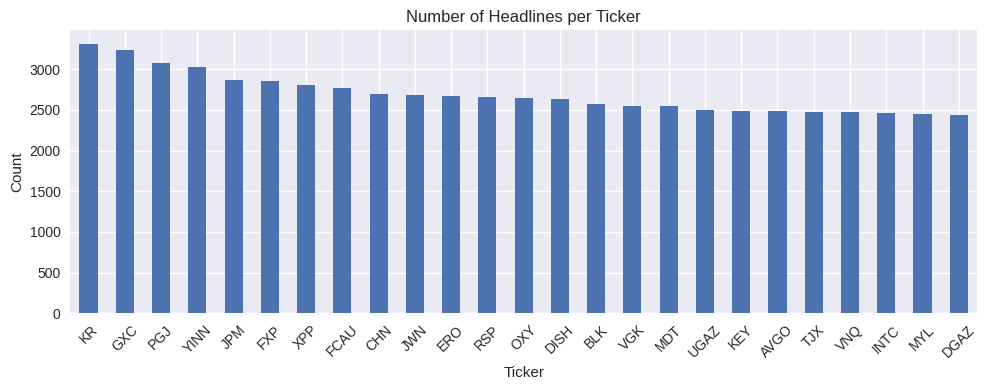

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Number of headlines per ticker
plt.figure(figsize=(10, 4))
news_df["ticker"].value_counts().plot(kind="bar")
plt.title("Number of Headlines per Ticker")
plt.xlabel("Ticker")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



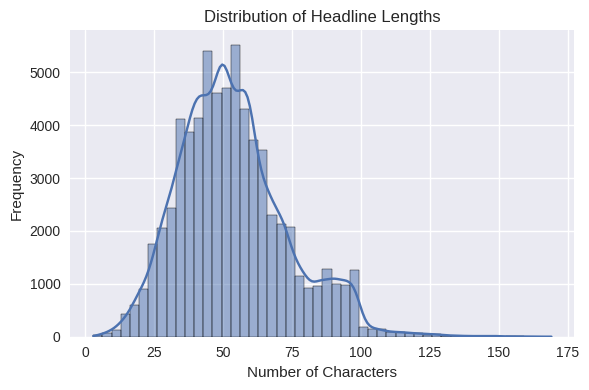

In [ ]:

# Headline length distribution
news_df["headline_len"] = news_df["headline"].str.len()

plt.figure(figsize=(6, 4))
sns.histplot(news_df["headline_len"], bins=50, kde=True)
plt.title("Distribution of Headline Lengths")
plt.xlabel("Number of Characters")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# remove helper column
news_df.drop(columns=["headline_len"], inplace=True)

In [ ]:
import yfinance as yf
import pandas as pd
# Download price data
def download_prices(ticker_list, start, end):
    frames = []

    for t in ticker_list:
        print("Downloading:", t)

        df = yf.download(
            tickers=[t],
            start=start,
            end=end,
            progress=False,
            group_by="ticker"     # ensures MultiIndex structure
        )

        if df.empty:
            print("No data for", t)
            continue

        # Flatten multiindex column names
        df.columns = [
            (col[1] if isinstance(col, tuple) else col)
            for col in df.columns
        ]

        df['ticker'] = t
        df.reset_index(inplace=True)

        frames.append(df)

    if not frames:
        raise ValueError("No tickers downloaded")

    return pd.concat(frames, ignore_index=True)


In [ ]:
start_date = news_df['date'].min().strftime("%Y-%m-%d")
end_date   = news_df['date'].max().strftime("%Y-%m-%d")

prices_df = download_prices(valid_tickers, start_date, end_date)

print("Price Data Shape:", prices_df.shape)
prices_df.head()

Downloading: KR


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: GXC
Downloading: PGJ


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: YINN
Downloading: JPM


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: FXP
Downloading: XPP


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: ERO
Downloading: RSP
Downloading: OXY


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: BLK
Downloading: VGK


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: MDT
Downloading: KEY


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: AVGO
Downloading: TJX


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(
/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Downloading: VNQ
Downloading: INTC


/tmp/ipython-input-3790827248.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(


Price Data Shape: (44858, 7)


,Date,Open,High,Low,Close,Volume,ticker
0,2010-02-04,7.915873,8.000910,7.812349,7.823441,21101000,KR
1,2010-02-05,7.819743,7.897386,7.764284,7.830835,15802000,KR
2,2010-02-08,7.827141,7.878903,7.745801,7.812352,12450600,KR
3,2010-02-09,7.912176,7.915873,7.841927,7.901084,10143600,KR
4,2010-02-10,7.902936,7.947501,7.865798,7.884367,9254800,KR


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

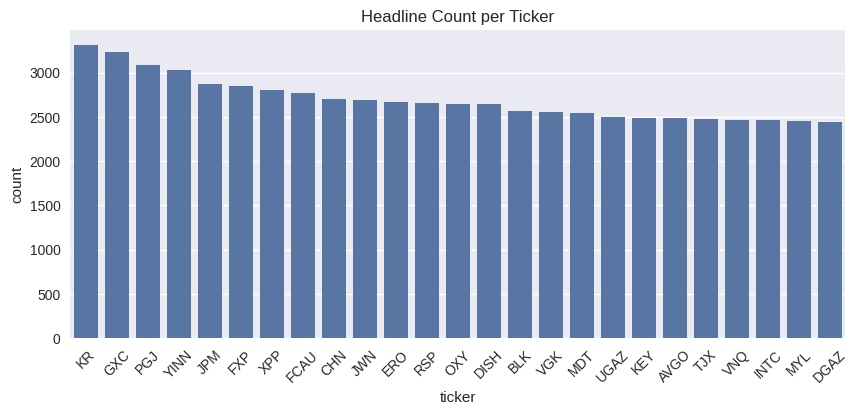

In [ ]:
# DAta Visusalization
plt.figure(figsize=(10,4))
sns.countplot(data=news_df, x='ticker', order=news_df['ticker'].value_counts().index)
plt.title("Headline Count per Ticker")
plt.xticks(rotation=45)
plt.show()

Normalize Cloumns

In [ ]:
# Convert column names to lowercase
prices_df.columns = [c.lower() for c in prices_df.columns]

prices_df = prices_df.rename(columns={
    'date': 'date',
    'open': 'open',
    'high': 'high',
    'low': 'low',
    'close': 'close',
    'adj close': 'adj_close',
    'volume': 'volume'
})

prices_df.head()

,date,open,high,low,close,volume,ticker
0,2010-02-04,7.915873,8.000910,7.812349,7.823441,21101000,KR
1,2010-02-05,7.819743,7.897386,7.764284,7.830835,15802000,KR
2,2010-02-08,7.827141,7.878903,7.745801,7.812352,12450600,KR
3,2010-02-09,7.912176,7.915873,7.841927,7.901084,10143600,KR
4,2010-02-10,7.902936,7.947501,7.865798,7.884367,9254800,KR


In [ ]:
import ta
# Technical Indicators
def add_ta(df):
    df = df.sort_values("date").copy()
    df["ma10"] = df["close"].rolling(10).mean()
    df["ma20"] = df["close"].rolling(20).mean()
    df["volatility"] = df["close"].pct_change().rolling(20).std()
    df["rsi14"] = ta.momentum.RSIIndicator(df["close"], 14).rsi()
    return df

prices_ta = prices_df.groupby("ticker", group_keys=False).apply(add_ta)
prices_ta.head()

/tmp/ipython-input-4210701099.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_ta = prices_df.groupby("ticker", group_keys=False).apply(add_ta)


,date,open,high,low,close,volume,ticker,ma10,ma20,volatility,rsi14
0,2010-02-04,7.915873,8.000910,7.812349,7.823441,21101000,KR,NaN,NaN,NaN,NaN
1,2010-02-05,7.819743,7.897386,7.764284,7.830835,15802000,KR,NaN,NaN,NaN,NaN
2,2010-02-08,7.827141,7.878903,7.745801,7.812352,12450600,KR,NaN,NaN,NaN,NaN
3,2010-02-09,7.912176,7.915873,7.841927,7.901084,10143600,KR,NaN,NaN,NaN,NaN
4,2010-02-10,7.902936,7.947501,7.865798,7.884367,9254800,KR,NaN,NaN,NaN,NaN


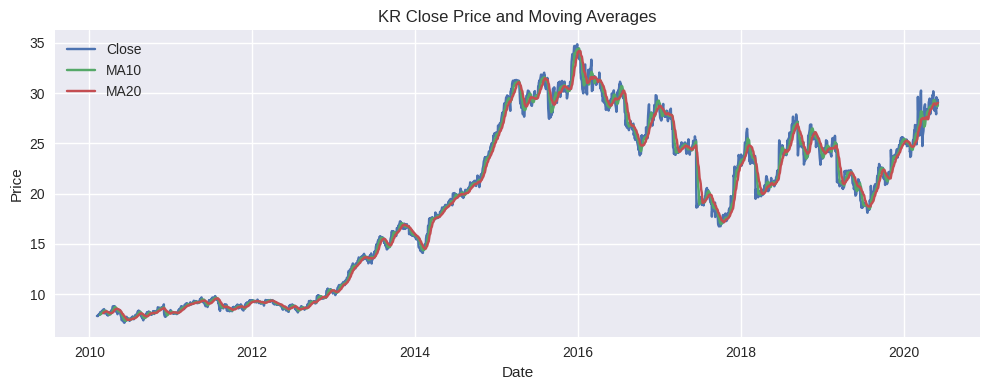

In [ ]:
sample_ticker = prices_ta["ticker"].iloc[0]  # or set to "JPM", "KR", etc.
sample_df = prices_ta[prices_ta["ticker"] == sample_ticker].sort_values("date")

plt.figure(figsize=(10, 4))
plt.plot(sample_df["date"], sample_df["close"], label="Close")
plt.plot(sample_df["date"], sample_df["ma10"], label="MA10")
plt.plot(sample_df["date"], sample_df["ma20"], label="MA20")
plt.title(f"{sample_ticker} Close Price and Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.tight_layout()
plt.show()

Multi day Returns

In [ ]:
'''
HORIZON = 5
THRESH = 0.003
'''

'\nHORIZON = 5\nTHRESH = 0.003\n'

In [ ]:
def add_labels(df, threshold=0.002):
    df = df.sort_values("date").copy()

    df["next_close_5"] = df["close"].shift(-5)
    df["ret5"] = (df["next_close_5"] - df["close"]) / df["close"]

    def classify(r):
        if r > threshold:
            return 1
        elif r < -threshold:
            return -1
        else:
            return 0

    df["direction"] = df["ret5"].apply(lambda r: 1 if r > threshold else -1 if r < -threshold else 0)
    return df

prices_final = prices_ta.groupby("ticker", group_keys=False).apply(add_labels)

/tmp/ipython-input-22318144.py:18: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  prices_final = prices_ta.groupby("ticker", group_keys=False).apply(add_labels)


In [ ]:
'''
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from tqdm import tqdm

device = 0 if torch.cuda.is_available() else -1
print("Using device:", device)

tokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")
model = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")

finbert = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    return_all_scores=True,
    device= -1,
    truncation=True,
    max_length=128
)
'''

'\nimport torch\nfrom transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline\nfrom tqdm import tqdm\n\ndevice = 0 if torch.cuda.is_available() else -1\nprint("Using device:", device)\n\ntokenizer = AutoTokenizer.from_pretrained("ProsusAI/finbert")\nmodel = AutoModelForSequenceClassification.from_pretrained("ProsusAI/finbert")\n\nfinbert = pipeline(\n    "text-classification",\n    model=model,\n    tokenizer=tokenizer,\n    return_all_scores=True,\n    device= -1,\n    truncation=True,\n    max_length=128\n)\n'

FINBERT SENTIMENT EXTRACTION

In [ ]:
def clean_text(t):
    return re.sub(r"[^\x00-\x7F]+", " ", str(t))

news_df["clean_headline"] = news_df["headline"].apply(clean_text)

In [ ]:
# load HF TOKEN
#HF_TOKEN = "secret"

from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
import torch, re

model_name = "yiyanghkust/finbert-tone"

print("Loading distilled FinBERT:", model_name)

# GPU or CPU
device = 0 if torch.cuda.is_available() else -1
print("Using device:", device)


# Load tokenizer & model
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    #token=HF_TOKEN
)

model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    #token=HF_TOKEN
)

finbert = pipeline(
    "text-classification",
    model=model,
    tokenizer=tokenizer,
    top_k=None,
    device=device,
)

Loading distilled FinBERT: yiyanghkust/finbert-tone
Using device: 0


config.json:   0%|          | 0.00/533 [00:00<?, ?B/s]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/439M [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
def score_to_scalar(scores):
    d = {s['label'].lower(): s['score'] for s in scores}
    return d.get('positive', 0) - d.get('negative', 0)

In [ ]:
def score_to_scalar(scores):
    d = {s['label'].lower(): s['score'] for s in scores}
    return d.get("positive", 0) - d.get("negative", 0)

from tqdm.notebook import tqdm

def run_finbert(texts, batch_size=32):
    results = []
    for i in tqdm(range(0, len(texts), batch_size), disable=True):
        batch = texts[i:i+batch_size]
        out = finbert(batch)
        results.extend([score_to_scalar(o) for o in out])
    return results

news_df["sentiment"] = run_finbert(news_df["clean_headline"].tolist())

model.safetensors:   0%|          | 0.00/439M [00:00<?, ?B/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


SentenceTransformer embeddings (384 dims)

In [ ]:
embedder = SentenceTransformer("all-MiniLM-L6-v2")

news_df["embedding"] = embedder.encode(
    news_df["clean_headline"].tolist(),
    batch_size=64,
    show_progress_bar=True
).tolist()

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/1054 [00:00<?, ?it/s]

Daily Sentiment Dataset

In [ ]:
daily = (
    news_df.groupby(["ticker", news_df["date"].dt.date])
    .agg(
        mean_sent=("sentiment", "mean"),
        sum_sent=("sentiment", "sum"),
        n_headlines=("headline", "count"),
        embedding=("embedding", lambda x: np.mean(x.tolist(), axis=0))
    )
    .reset_index()
)

daily["date"] = pd.to_datetime(daily["date"])
daily.head()

,ticker,date,mean_sent,sum_sent,n_headlines,embedding
0,AVGO,2016-10-31,0.271329,0.542659,2,"[-0.004339324310421944, 0.02035677619278431, 0..."
1,AVGO,2016-11-01,0.002663,0.010651,4,"[0.0029833074659109116, -0.0717070116661489, 0..."
2,AVGO,2016-11-02,0.086871,0.694966,8,"[-0.015922904247418046, -0.033086022129282355,..."
3,AVGO,2016-11-03,0.190928,0.763713,4,"[-0.023237247951328754, -0.023970282782102004,..."
4,AVGO,2016-11-04,0.320189,0.960568,3,"[-0.05454399809241295, -0.025917984545230865, ..."


Merge Prices + Sentiment

In [ ]:
merged = prices_final.merge(daily, on=["ticker", "date"], how="left")

merged["mean_sent"] = merged["mean_sent"].fillna(0)
merged["sum_sent"]  = merged["sum_sent"].fillna(0)
merged["n_headlines"] = merged["n_headlines"].fillna(0)

# Fill embedding if no news
embed_dim = len(daily["embedding"].iloc[0])
merged["embedding"] = merged["embedding"].apply(
    lambda x: np.zeros(embed_dim) if isinstance(x, float) else x
)

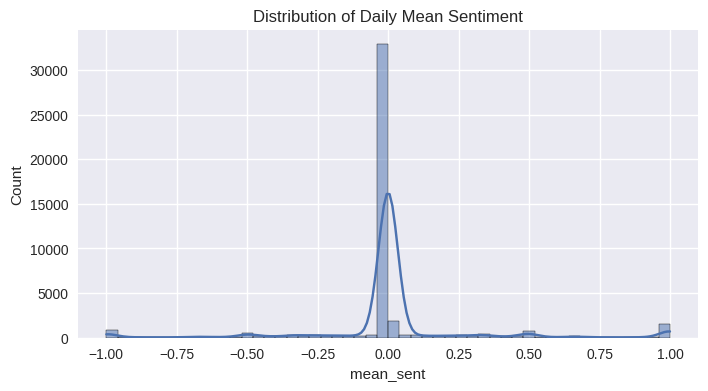

In [ ]:
plt.figure(figsize=(8,4))
sns.histplot(merged['mean_sent'], bins=50, kde=True)
plt.title("Distribution of Daily Mean Sentiment")
plt.show()

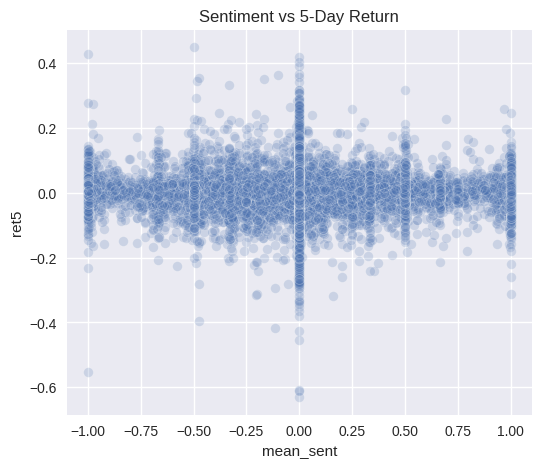

In [ ]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    data=merged,
    x='mean_sent',
    y='ret5',
    alpha=0.2
)
plt.title("Sentiment vs 5-Day Return")
plt.show()

Feature Selection

In [ ]:
price_features = ["open","high","low","close","volume","ma10","ma20","volatility","rsi14",
                  "mean_sent","sum_sent","n_headlines"]

embed_features = [f"emb_{i}" for i in range(embed_dim)]

merged[embed_features] = pd.DataFrame(merged["embedding"].tolist(), index=merged.index)

feature_cols = price_features + embed_features

/tmp/ipython-input-2886599598.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[embed_features] = pd.DataFrame(merged["embedding"].tolist(), index=merged.index)
/tmp/ipython-input-2886599598.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  merged[embed_features] = pd.DataFrame(merged["embedding"].tolist(), index=merged.index)
/tmp/ipython-input-2886599598.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider jo

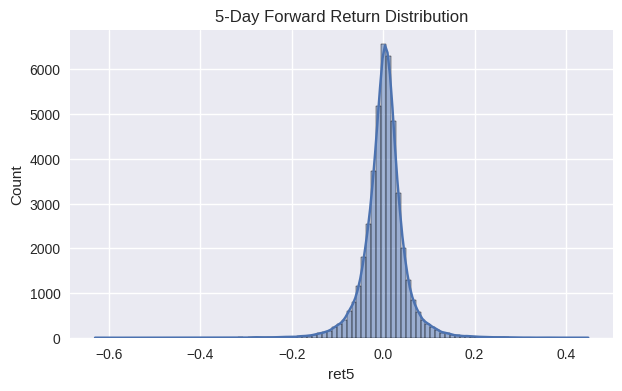

In [ ]:
plt.figure(figsize=(7,4))
sns.histplot(prices_final['ret5'], bins=100, kde=True)
plt.title("5-Day Forward Return Distribution")
plt.show()

In [ ]:
ml_df = merged.dropna(subset=feature_cols + ["direction"])

cut = ml_df["date"].quantile(0.8)

train = ml_df[ml_df["date"] <= cut]
test  = ml_df[ml_df["date"] > cut]

X_train = train[feature_cols]
y_train = train["direction"]

X_test = test[feature_cols]
y_test = test["direction"]

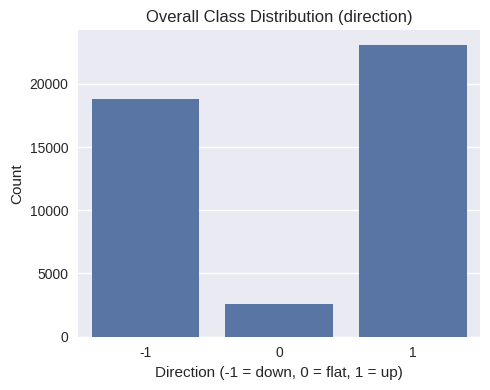

In [ ]:
# Overall direction distribution
plt.figure(figsize=(5, 4))
sns.countplot(x=ml_df["direction"])
plt.title("Overall Class Distribution (direction)")
plt.xlabel("Direction (-1 = down, 0 = flat, 1 = up)")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

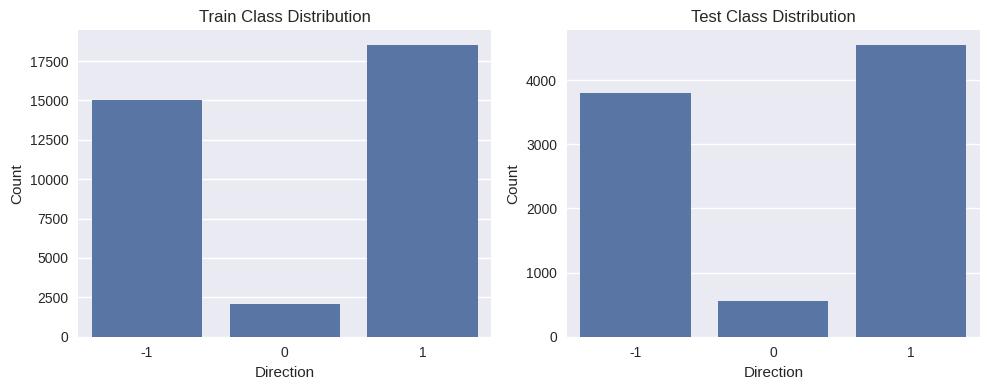

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title("Train Class Distribution")
plt.xlabel("Direction")
plt.ylabel("Count")

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title("Test Class Distribution")
plt.xlabel("Direction")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Model Trainig

Random Forest

In [ ]:
rf = RandomForestClassifier(
    n_estimators=400,
    max_depth=20,
    n_jobs=-1
)
rf.fit(X_train_scaled, y_train)
pred_rf = rf.predict(X_test_scaled)

In [ ]:
def evaluate(name, y_true, y_pred):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred))

evaluate("Random Forest", y_test, pred_rf)

Accuracy: 0.5076473234367971
              precision    recall  f1-score   support

          -1       0.45      0.08      0.14      3791
           0       0.00      0.00      0.00       554
           1       0.51      0.92      0.66      4547

    accuracy                           0.51      8892
   macro avg       0.32      0.34      0.27      8892
weighted avg       0.45      0.51      0.40      8892



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


CATBOOST


In [ ]:
cb = CatBoostClassifier(
    depth=10,
    learning_rate=0.02,
    iterations=1000,
    loss_function="MultiClass",
    task_type="GPU",
    verbose=False
)
cb.fit(X_train_scaled, y_train)
pred_cb = cb.predict(X_test_scaled)

In [ ]:
evaluate("CatBoost", y_test, pred_cb)

Accuracy: 0.5001124606387765
              precision    recall  f1-score   support

          -1       0.44      0.21      0.28      3791
           0       0.00      0.00      0.00       554
           1       0.52      0.81      0.63      4547

    accuracy                           0.50      8892
   macro avg       0.32      0.34      0.30      8892
weighted avg       0.45      0.50      0.44      8892



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


XGBoost

In [ ]:
import numpy as np

# Remap {-1,0,1} → {0,1,2}
y_train_xgb = np.where(y_train == -1, 0, np.where(y_train == 0, 1, 2))
y_test_xgb  = np.where(y_test == -1, 0, np.where(y_test == 0, 1, 2))


In [ ]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    objective="multi:softmax",
    num_class=3,
    eval_metric="mlogloss",
    learning_rate=0.05,
    max_depth=5,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist"
)

xgb.fit(X_train_scaled, y_train_xgb)
pred_xgb = xgb.predict(X_test_scaled)


In [ ]:
pred_xgb_final = np.where(pred_xgb == 0, -1, np.where(pred_xgb == 1, 0, 1))

In [ ]:
evaluate("XGBoost", y_test, pred_xgb_final)

Accuracy: 0.49460188933873145
              precision    recall  f1-score   support

          -1       0.43      0.23      0.30      3791
           0       0.00      0.00      0.00       554
           1       0.51      0.78      0.62      4547

    accuracy                           0.49      8892
   macro avg       0.31      0.34      0.31      8892
weighted avg       0.45      0.49      0.44      8892



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


LightGBM

In [ ]:
y_train_lgb = y_train.map({-1:0, 0:1, 1:2})
y_test_lgb  = y_test.map({-1:0, 0:1, 1:2})

In [ ]:
alive_features = [c for c in feature_cols if ml_df[c].nunique() > 1]
# quick RF to get feature importance
from sklearn.ensemble import RandomForestClassifier

tmp_rf = RandomForestClassifier(n_estimators=200, n_jobs=-1)
tmp_rf.fit(X_train[alive_features], y_train_lgb)

importances = pd.Series(tmp_rf.feature_importances_, index=alive_features)
top50 = importances.sort_values(ascending=False).head(50).index.tolist()

X_train_lgb = X_train[top50]
X_test_lgb  = X_test[top50]

In [ ]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    max_depth=-1,
    num_leaves=20,
    min_gain_to_split=0.0,
    min_child_samples=40,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="multiclass",
    num_class=3,
    force_row_wise=True
)

lgb.fit(X_train_lgb, y_train_lgb)
pred_lgb = lgb.predict(X_test_lgb)


[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 35606, number of used features: 50
[LightGBM] [Info] Start training from score -0.862666
[LightGBM] [Info] Start training from score -2.853212
[LightGBM] [Info] Start training from score -0.653339
[LightGBM] [Warning] min_gain_to_split is set=0.0, min_split_gain=0.0 will be ignored. Current value: min_gain_to_split=0.0


In [ ]:
evaluate("LightGBM", y_test_lgb, pred_lgb)

Accuracy: 0.48819163292847506
              precision    recall  f1-score   support

           0       0.42      0.25      0.31      3791
           1       0.00      0.00      0.00       554
           2       0.51      0.75      0.61      4547

    accuracy                           0.49      8892
   macro avg       0.31      0.33      0.31      8892
weighted avg       0.44      0.49      0.44      8892



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Ensemble

In [ ]:
print("RF:", np.array(pred_rf).shape)
print("CB:", np.array(pred_cb).shape)
print("XGB:", np.array(pred_xgb).shape)
print("LGB:", np.array(pred_lgb).shape)

RF: (8892,)
CB: (8892, 1)
XGB: (8892,)
LGB: (8892,)


In [ ]:
pred_cb = np.array(pred_cb).reshape(-1)

In [ ]:
def decode_012_to_direction(arr):
    mapping = {0: -1, 1: 0, 2: 1}
    return np.vectorize(mapping.get)(arr)

In [ ]:
pred_xgb_dec = decode_012_to_direction(pred_xgb)
pred_lgb_dec = decode_012_to_direction(pred_lgb)

In [ ]:
import numpy as np

pred_stack = pred_stack = np.vstack([
    pred_rf,
    pred_cb,
    pred_xgb_dec,
    pred_lgb_dec
]).T
weights = np.array([2, 2, 1.0, 1.0])
ensemble_pred = np.round((pred_stack * weights).sum(axis=1) / weights.sum()).astype(int)


In [ ]:
evaluate("Ensemble", y_test, ensemble_pred)

Accuracy: 0.4013720197930724
              precision    recall  f1-score   support

          -1       0.47      0.04      0.07      3791
           0       0.07      0.29      0.11       554
           1       0.51      0.72      0.60      4547

    accuracy                           0.40      8892
   macro avg       0.35      0.35      0.26      8892
weighted avg       0.47      0.40      0.34      8892



SVM - RFB Kernel

In [ ]:
'''
from sklearn.svm import SVC

# Initialize svm_rbf before using it
svm_rbf = SVC(
    kernel="linear",
    C=1.0,
    gamma="scale"
)

train_small = train.sample(10000, random_state=123)

svm_rbf.fit(
    scaler.transform(train_small[feature_cols]),
    train_small["direction"]
)

svm_rbf.fit(X_train_scaled, y_train)

pred_svm_rbf = svm_rbf.predict(X_test_scaled)

print("SVM (RBF) Accuracy:", accuracy_score(y_test, pred_svm_rbf))
print(classification_report(y_test, pred_svm_rbf))
'''

'\nfrom sklearn.svm import SVC\n\n# Initialize svm_rbf before using it\nsvm_rbf = SVC(\n    kernel="linear",\n    C=1.0,\n    gamma="scale"\n)\n\ntrain_small = train.sample(10000, random_state=123)\n\nsvm_rbf.fit(\n    scaler.transform(train_small[feature_cols]),\n    train_small["direction"]\n)\n\nsvm_rbf.fit(X_train_scaled, y_train)\n\npred_svm_rbf = svm_rbf.predict(X_test_scaled)\n\nprint("SVM (RBF) Accuracy:", accuracy_score(y_test, pred_svm_rbf))\nprint(classification_report(y_test, pred_svm_rbf))\n'

In [ ]:
model_names = []
accuracies = []

def collect(name, pred):
    model_names.append(name)
    accuracies.append(accuracy_score(y_test, pred))

# models
collect("Random Forest", pred_rf)
collect("CatBoost", pred_cb)
collect("XGBoost", pred_xgb_dec)
collect("LightGBM", pred_lgb_dec)
#collect("SVM (Linear)", pred_svm_rbf)

In [ ]:
importances = rf.feature_importances_

In [ ]:
# Sort descending
idx = np.argsort(importances)[::-1][:10]
top_features = np.array(feature_cols)[idx]
top_values = importances[idx]

/tmp/ipython-input-2894519926.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values[::-1], y=top_features[::-1], palette="viridis")


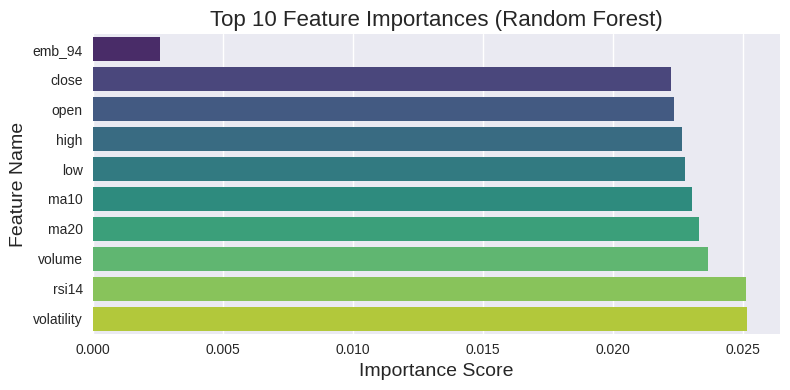

In [ ]:
plt.figure(figsize=(8, 4))
sns.barplot(x=top_values[::-1], y=top_features[::-1], palette="viridis")

plt.title("Top 10 Feature Importances (Random Forest)", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)

plt.tight_layout()
plt.show()

In [ ]:
feat_names = np.array(feature_cols)
sorted_idx = np.argsort(importances)[::-1]

sorted_importances = importances[sorted_idx]
sorted_features = feat_names[sorted_idx]

# Compute cumulative importance
cumulative_importance = np.cumsum(sorted_importances)

# Put into a dataframe for display
imp_df = pd.DataFrame({
    "feature": sorted_features,
    "importance": sorted_importances,
    "cumulative_importance": cumulative_importance
})

# Show the top features until 80% is reached
imp_df[imp_df["cumulative_importance"] <= 0.80]

,feature,importance,cumulative_importance
0,volatility,0.025178,0.025178
1,rsi14,0.025124,0.050302
2,volume,0.023655,0.073957
3,ma20,0.023312,0.097269
4,ma10,0.023064,0.120333
...,...,...,...
286,emb_360,0.001976,0.791731
287,emb_272,0.001976,0.793707
288,emb_48,0.001976,0.795683
289,emb_294,0.001973,0.797656


In [ ]:
# save these in a file
top80 = imp_df[imp_df["cumulative_importance"] <= 0.80]
top80.to_csv("multi_ticker_top_features.txt",
             sep="\t",      # tab-separated
             index=False,
             header=True)

/tmp/ipython-input-2430516250.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_values, y=model_names, palette="coolwarm")


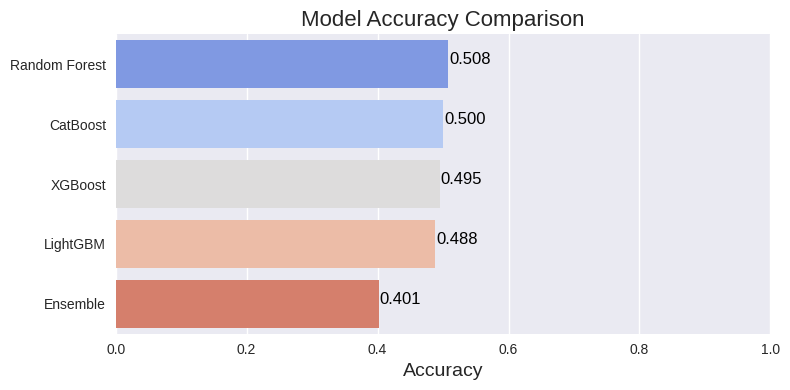

In [ ]:
model_names = [
    "Random Forest",
    "CatBoost",
    "XGBoost",
    "LightGBM",
    "Ensemble",
    #"SVM (Linear)"
]

acc_values = [
    accuracy_score(y_test, pred_rf),
    accuracy_score(y_test, pred_cb),
    accuracy_score(y_test, pred_xgb_dec),
    accuracy_score(y_test, pred_lgb_dec),
    accuracy_score(y_test, ensemble_pred),
    #accuracy_score(y_test, pred_svm_rbf)
]

plt.figure(figsize=(8, 4))
sns.barplot(x=acc_values, y=model_names, palette="coolwarm")

for i, v in enumerate(acc_values):
    plt.text(v + 0.002, i, f"{v:.3f}", fontsize=12, color="black")

plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
plt.xlim(0, 1)

plt.tight_layout()
plt.show()

# Binary Classification

In [ ]:
binary_df = ml_df[ml_df["direction"] != 0].copy()

binary_df["binary_dir"] = binary_df["direction"].map({
    -1: 0,   # DOWN → 0
     1: 1    # UP   → 1
})

In [ ]:
cut = binary_df["date"].quantile(0.8)

train_bin = binary_df[binary_df["date"] <= cut]
test_bin  = binary_df[binary_df["date"] > cut]

X_train_bin = train_bin[feature_cols]
y_train_bin = train_bin["binary_dir"]

X_test_bin = test_bin[feature_cols]
y_test_bin = test_bin["binary_dir"]

In [ ]:
scaler_bin = StandardScaler()
X_train_bin_scaled = scaler_bin.fit_transform(X_train_bin)
X_test_bin_scaled  = scaler_bin.transform(X_test_bin)

In [ ]:
rf_bin = RandomForestClassifier(
    n_estimators=400,
    max_depth=15,
    n_jobs=-1
)

rf_bin.fit(X_train_bin_scaled, y_train_bin)
pred_rf_bin = rf_bin.predict(X_test_bin_scaled)

In [ ]:
from xgboost import XGBClassifier

xgb_bin = XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    learning_rate=0.03,
    max_depth=6,
    n_estimators=400,
    subsample=0.8,
    colsample_bytree=0.8,
    tree_method="hist"
)

xgb_bin.fit(X_train_bin_scaled, y_train_bin)
pred_xgb_bin = (xgb_bin.predict_proba(X_test_bin_scaled)[:,1] > 0.5).astype(int)

In [ ]:
from catboost import CatBoostClassifier

cb_bin = CatBoostClassifier(
    depth=8,
    learning_rate=0.03,
    iterations=100,
    loss_function="Logloss",
    task_type="CPU",
    verbose=False
)

cb_bin.fit(X_train_bin, y_train_bin)
pred_cb_bin = cb_bin.predict(X_test_bin)
pred_cb_bin = pred_cb_bin.astype(int)


In [ ]:
lgb_bin = LGBMClassifier(
    n_estimators=500,
    learning_rate=0.03,
    objective="binary",
    num_leaves=20,
    subsample=0.8,
    colsample_bytree=0.8,
)

lgb_bin.fit(X_train_bin[top50], y_train_bin)
pred_lgb_bin = (lgb_bin.predict(X_test_bin[top50]) > 0.5).astype(int)

[LightGBM] [Info] Number of positive: 18517, number of negative: 15004
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005714 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 12750
[LightGBM] [Info] Number of data points in the train set: 33521, number of used features: 50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.552400 -> initscore=0.210372
[LightGBM] [Info] Start training from score 0.210372


In [ ]:
from sklearn.metrics import accuracy_score, classification_report

def evaluate_bin(name, y_true, y_pred):
    print(f"{name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print(classification_report(y_true, y_pred, target_names=["Down", "Up"]))

In [ ]:
pred_stack_bin = np.vstack([
    pred_rf_bin,
    pred_cb_bin,
    pred_xgb_bin,
    pred_lgb_bin
]).T

weights_bin = np.array([2, 2, 1, 1])

ensemble_pred_bin = np.round(
    (pred_stack_bin * weights_bin).sum(axis=1) / weights_bin.sum()
).astype(int)



In [ ]:
'''
train_small_bin = train_bin.sample(10000, random_state=123)

X_train_small_bin = train_small_bin[feature_cols]
y_train_small_bin = train_small_bin["binary_dir"]

X_train_small_bin_scaled = scaler_bin.fit_transform(X_train_small_bin)
X_test_bin_scaled        = scaler_bin.transform(X_test_bin)
'''

'\ntrain_small_bin = train_bin.sample(10000, random_state=123)\n\nX_train_small_bin = train_small_bin[feature_cols]\ny_train_small_bin = train_small_bin["binary_dir"]\n\nX_train_small_bin_scaled = scaler_bin.fit_transform(X_train_small_bin)\nX_test_bin_scaled        = scaler_bin.transform(X_test_bin)\n'

In [ ]:
'''
svm_bin = SVC(
    kernel="linear",
    C=2.0,
    gamma="scale"
)

svm_bin.fit(X_train_small_bin_scaled, y_train_small_bin)
pred_svm_bin = svm_bin.predict(X_test_bin_scaled)
'''

'\nsvm_bin = SVC(\n    kernel="linear",\n    C=2.0,\n    gamma="scale"\n)\n\nsvm_bin.fit(X_train_small_bin_scaled, y_train_small_bin)\npred_svm_bin = svm_bin.predict(X_test_bin_scaled)\n'

In [ ]:
evaluate_bin("Random Forest", y_test_bin, pred_rf_bin)
evaluate_bin("XGBoost",      y_test_bin, pred_xgb_bin)
evaluate_bin("CatBoost",     y_test_bin, pred_cb_bin)
evaluate_bin("LightGBM",     y_test_bin, pred_lgb_bin)
evaluate_bin("Binary Ensemble", y_test_bin, ensemble_pred_bin)
# evaluate_bin("SVM (Linear)",    y_test_bin, pred_svm_bin)

Random Forest
Accuracy: 0.5426523297491039
              precision    recall  f1-score   support

        Down       0.48      0.05      0.10      3814
          Up       0.55      0.95      0.69      4556

    accuracy                           0.54      8370
   macro avg       0.51      0.50      0.40      8370
weighted avg       0.52      0.54      0.42      8370

XGBoost
Accuracy: 0.533094384707288
              precision    recall  f1-score   support

        Down       0.47      0.19      0.27      3814
          Up       0.55      0.82      0.66      4556

    accuracy                           0.53      8370
   macro avg       0.51      0.51      0.46      8370
weighted avg       0.51      0.53      0.48      8370

CatBoost
Accuracy: 0.5415770609318996
              precision    recall  f1-score   support

        Down       0.47      0.05      0.09      3814
          Up       0.55      0.95      0.69      4556

    accuracy                           0.54      8370
   macro av

/tmp/ipython-input-2155295080.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=acc_values, y=model_names, palette="coolwarm")


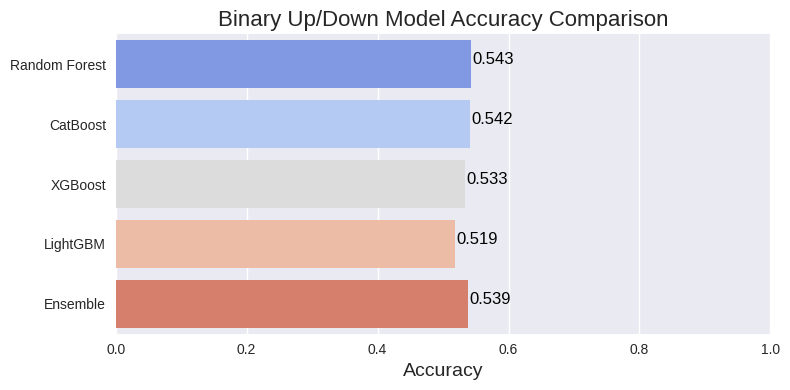

In [ ]:
model_names = [
    "Random Forest",
    "CatBoost",
    "XGBoost",
    "LightGBM",
    # "SVM (Linear)",
    "Ensemble"
]

acc_values = [
    accuracy_score(y_test_bin, pred_rf_bin),
    accuracy_score(y_test_bin, pred_cb_bin),
    accuracy_score(y_test_bin, pred_xgb_bin),
    accuracy_score(y_test_bin, pred_lgb_bin),
    #accuracy_score(y_test_bin, pred_svm_bin),
    accuracy_score(y_test_bin, ensemble_pred_bin)
]

plt.figure(figsize=(8, 4))
sns.barplot(x=acc_values, y=model_names, palette="coolwarm")

for i, v in enumerate(acc_values):
    plt.text(v + 0.002, i, f"{v:.3f}", fontsize=12, color="black")

plt.title("Binary Up/Down Model Accuracy Comparison", fontsize=16)
plt.xlabel("Accuracy", fontsize=14)
plt.xlim(0, 1)

plt.tight_layout()
plt.show()


Single Ticker

In [ ]:
ticker = "AAPL"
import yfinance as yf
import pandas as pd

df = yf.Ticker(ticker).history(period="3y").reset_index()
df["date"] = pd.to_datetime(df["Date"])

In [ ]:
df["ma10"] = df["Close"].rolling(10).mean()
df["ma20"] = df["Close"].rolling(20).mean()
df["volatility"] = df["Close"].pct_change().rolling(20).std()
df["rsi14"] = df["Close"].pct_change().rolling(14).apply(
    lambda x: 100 - (100 / (1 + (x[x>0].mean() / abs(x[x<0].mean())))))
df = df.dropna()


In [ ]:
def cls3(r, thr=0.002):
    if r > thr: return 1
    if r < -thr: return -1
    return 0

In [ ]:
df["next_close_5"] = df["Close"].shift(-5)
df["ret5"] = (df["next_close_5"] - df["Close"]) / df["Close"]

df["direction_3c"] = df["ret5"].apply(cls3)
df["direction_2c"] = (df["direction_3c"] == 1).astype(int)
df = df.dropna()

In [ ]:
feature_cols_s = ["Open", "High", "Low", "Close", "Volume",
                "ma10", "ma20", "volatility"]
X = df[feature_cols_s]
y3 = df["direction_3c"]
y2 = df["direction_2c"]

In [ ]:
def walk_forward_split(df, train_size=0.7, step=60):
    n = len(df)
    train_end = int(n * train_size)

    splits = []
    i = train_end

    while i + step < n:
        train_idx = range(0, i)
        test_idx = range(i, i+step)
        splits.append((train_idx, test_idx))
        i += step

    return splits

In [ ]:
results_3c = []
splits = walk_forward_split(df, train_size=0.7, step=60)

for train_idx, test_idx in splits:

    X_train = X.iloc[train_idx]
    y_train = y3.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_test  = y3.iloc[test_idx]

    # scale for RF / XGB / LGB
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Random Forest
    rf3 = RandomForestClassifier(n_estimators=300, random_state=42)
    rf3.fit(X_train_scaled, y_train)
    pred_rf3 = rf3.predict(X_test_scaled)

    # XGBoost (with remapped labels)
    y3_train_xgb = y_train.map({-1:0, 0:1, 1:2})
    xgb3 = XGBClassifier(
        num_class=3,
        objective="multi:softmax",
        eval_metric="mlogloss",
        random_state=42
    )
    xgb3.fit(X_train_scaled, y3_train_xgb)
    pred_xgb3 = xgb3.predict(X_test_scaled)
    pred_xgb3 = pd.Series(pred_xgb3).map({0:-1, 1:0, 2:1})

    # LightGBM
    lgb3 = LGBMClassifier(
        objective="multiclass",
        num_class=3,
        random_state=42
    )
    lgb3.fit(X_train_scaled, y_train)
    pred_lgb3 = lgb3.predict(X_test_scaled)

    # CatBoost (train on unscaled)
    cb3 = CatBoostClassifier(
        iterations=300,
        depth=6,
        learning_rate=0.05,
        loss_function="MultiClass",
        verbose=False,
        random_state=42
    )
    cb3.fit(X_train, y_train)
    pred_cb3 = cb3.predict(X_test)

    # accuracy
    accs = {
        "rf":  accuracy_score(y_test, pred_rf3),
        "xgb": accuracy_score(y_test, pred_xgb3),
        "lgb": accuracy_score(y_test, pred_lgb3),
        "cb":  accuracy_score(y_test, pred_cb3)
    }

    results_3c.append(accs)

results_3c_df = pd.DataFrame(results_3c)
display(results_3c_df.mean())

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1360
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 8
[LightGBM] [Info] Start training from score -0.996006
[LightGBM] [Info] Start training from score -2.677100
[LightGBM] [Info] Start training from score -0.576456
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 8
[LightGBM] [Info] Start training from score -0.941203
[LightGBM] [Info] Start training from score -2.680319
[LightGBM] [Info] Start training from score -0.613781
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000110 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 8
[LightGBM] [Info] Start training from score -0.934743
[LightGBM] [Info] Start training from score -2.706462
[LightGBM] [Info] Start training from score -0.615186
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No fur

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,0
rf,0.411111
xgb,0.483333
lgb,0.483333
cb,0.483333


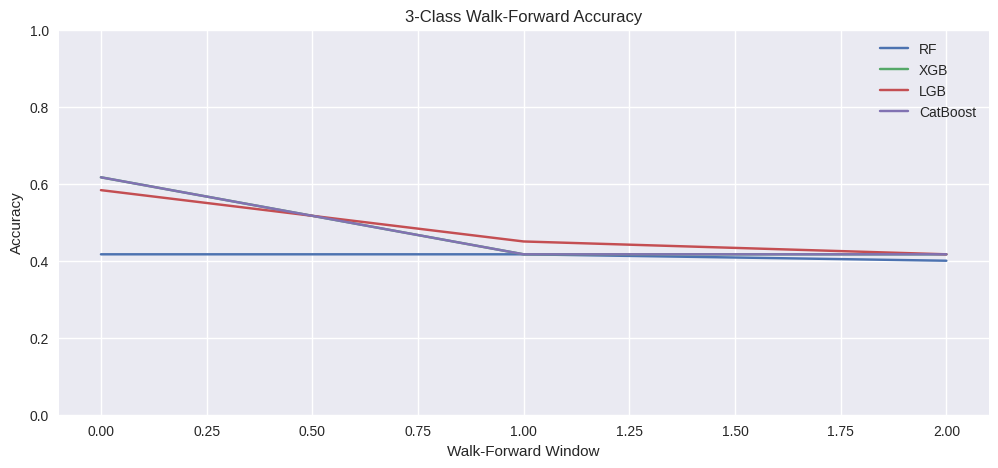

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(results_3c_df["rf"],  label="RF")
plt.plot(results_3c_df["xgb"], label="XGB")
plt.plot(results_3c_df["lgb"], label="LGB")
plt.plot(results_3c_df["cb"],  label="CatBoost")

plt.title("3-Class Walk-Forward Accuracy")
plt.xlabel("Walk-Forward Window")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()

In [ ]:
importances3 = rf3.feature_importances_

In [ ]:
feat_names3 = np.array(feature_cols_s)
sorted_idx3 = np.argsort(importances3)[::-1]

sorted_importances3 = importances3[sorted_idx3]
sorted_features3 = feat_names3[sorted_idx3]

# Compute cumulative importance
cumulative_importance3 = np.cumsum(sorted_importances3)

# Put into a dataframe for display
imp_df3 = pd.DataFrame({
    "feature": sorted_features3,
    "importance": sorted_importances3,
    "cumulative_importance3": cumulative_importance3
})

# Show the top features until 80% is reached
top80_s = imp_df3[imp_df3["cumulative_importance3"] <= 0.80]

# Save to TXT
top80_s.to_csv("Single_ticker_top_features.txt",
             sep="\t",
             index=False,
             header=True)

/tmp/ipython-input-3814366071.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_values3[::-1], y=top_features3[::-1], palette="viridis")


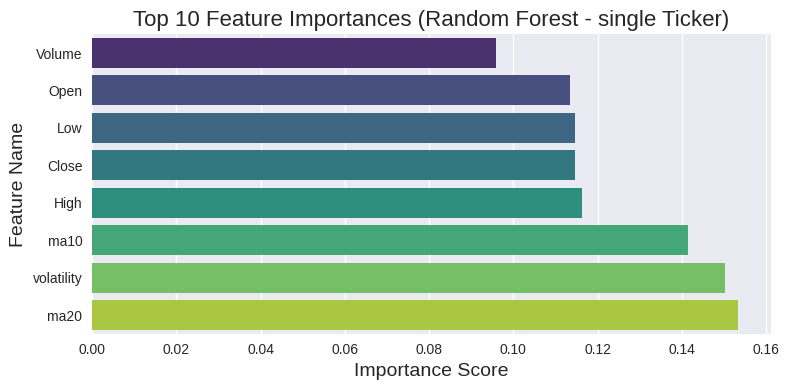

In [ ]:
idx3 = np.argsort(importances3)[::-1][:10]
top_features3 = np.array(feature_cols_s)[idx3]
top_values3 = importances3[idx3]
plt.figure(figsize=(8, 4))
sns.barplot(x=top_values3[::-1], y=top_features3[::-1], palette="viridis")

plt.title("Top 10 Feature Importances (Random Forest - single Ticker)", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature Name", fontsize=14)

plt.tight_layout()
plt.show()

2-class

In [ ]:
results_2c = []

for train_idx, test_idx in splits:

    X_train = X.iloc[train_idx]
    y_train = y2.iloc[train_idx]
    X_test  = X.iloc[test_idx]
    y_test  = y2.iloc[test_idx]

    # scale for RF / XGB / LGB
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled  = scaler.transform(X_test)

    # Random Forest
    rf2 = RandomForestClassifier(n_estimators=250, random_state=42)
    rf2.fit(X_train_scaled, y_train)
    pred_rf2 = rf2.predict(X_test_scaled)

    # XGBoost
    xgb2 = XGBClassifier(
        objective="binary:logistic",
        eval_metric="logloss",
        random_state=123
    )
    xgb2.fit(X_train_scaled, y_train)
    pred_xgb2 = (xgb2.predict_proba(X_test_scaled)[:,1] > 0.5).astype(int)

    # LightGBM
    lgb2 = LGBMClassifier(
        objective="binary",
        random_state=123
    )
    lgb2.fit(X_train_scaled, y_train)
    pred_lgb2 = (lgb2.predict_proba(X_test_scaled)[:,1] > 0.5).astype(int)

    # CatBoost
    cb2 = CatBoostClassifier(
        iterations=250,
        depth=6,
        learning_rate=0.05,
        loss_function="Logloss",
        verbose=False,
        random_state=123
    )
    cb2.fit(X_train, y_train)
    pred_cb2 = cb2.predict(X_test).astype(int)

    # collect accuracy
    accs = {
        "rf":  accuracy_score(y_test, pred_rf2),
        "xgb": accuracy_score(y_test, pred_xgb2),
        "lgb": accuracy_score(y_test, pred_lgb2),
        "cb":  accuracy_score(y_test, pred_cb2)
    }
    results_2c.append(accs)

results_2c_df = pd.DataFrame(results_2c)
display(results_2c_df.mean())


[LightGBM] [Info] Number of positive: 286, number of negative: 223
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000114 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1360
[LightGBM] [Info] Number of data points in the train set: 509, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.561886 -> initscore=0.248820
[LightGBM] [Info] Start training from score 0.248820
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 308, number of negative: 261
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1520
[LightGBM] [Info] Number of data points in the train set: 569, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.541301 -> initscore=0.165579
[LightGBM] [Info] Start training from score 0.165579
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Info] Number of positive: 340, number of negative: 289
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1680
[LightGBM] [Info] Number of data points in the train set: 629, number of used features: 8
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.540541 -> initscore=0.162519
[LightGBM] [Info] Start training from score 0.162519
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best g

/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


,0
rf,0.438889
xgb,0.583333
lgb,0.533333
cb,0.527778


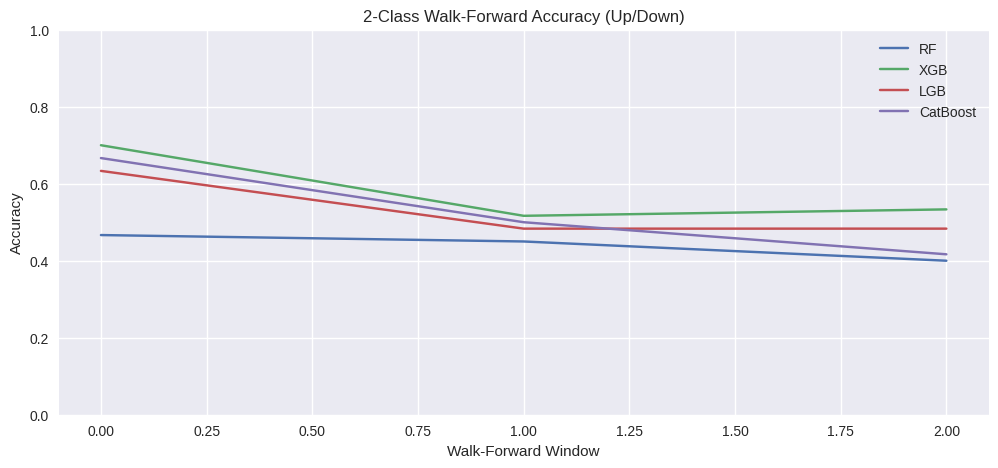

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(results_2c_df["rf"],  label="RF")
plt.plot(results_2c_df["xgb"], label="XGB")
plt.plot(results_2c_df["lgb"], label="LGB")
plt.plot(results_2c_df["cb"],  label="CatBoost")

plt.title("2-Class Walk-Forward Accuracy (Up/Down)")
plt.xlabel("Walk-Forward Window")
plt.ylabel("Accuracy")
plt.ylim(0, 1)
plt.legend()
plt.show()


In [ ]:
import pandas as pd

NEWS_PATH = "/content/drive/MyDrive/Feature_Engineering/raw_partner_headlines.csv"

news = pd.read_csv(NEWS_PATH)

# Clean dates
news["date"] = pd.to_datetime(news["date"]).dt.date

# Filter for AAPL only
aapl_news = news[news["stock"] == "AAPL"].copy()

In [ ]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
import numpy as np

# Load FinBERT
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-tone")
model = AutoModelForSequenceClassification.from_pretrained("yiyanghkust/finbert-tone")

def get_finbert_sentiment(text):
    try:
        inputs = tokenizer(text, return_tensors="pt", truncation=True)
        outputs = model(**inputs)
        scores = torch.softmax(outputs.logits, dim=1).detach().numpy()[0]
        # Labels: 0 NEGATIVE, 1 NEUTRAL, 2 POSITIVE
        return pd.Series({
            "sent_neg": scores[0],
            "sent_neu": scores[1],
            "sent_pos": scores[2]
        })
    except:
        return pd.Series({"sent_neg": 0, "sent_neu": 1, "sent_pos": 0})

# Apply sentiment
sent_cols = aapl_news["headline"].apply(get_finbert_sentiment)
aapl_news = pd.concat([aapl_news, sent_cols], axis=1)


Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


In [ ]:
daily_sent = (
    aapl_news.groupby("date")
    .agg({
        "sent_pos": "mean",
        "sent_neg": "mean",
        "sent_neu": "mean",
        "headline": "count"
    })
    .reset_index()
)

daily_sent.rename(columns={"headline": "news_count"}, inplace=True)


In [ ]:
from sentence_transformers import SentenceTransformer

embed_model = SentenceTransformer("sentence-transformers/all-MiniLM-L6-v2")

def get_embed(text):
    try:
        return embed_model.encode(text)
    except:
        return np.zeros(384)

# Compute embeddings
aapl_news["embedding"] = aapl_news["headline"].apply(get_embed)

# Daily averaged embedding
embed_dim = len(aapl_news["embedding"].iloc[0])

embed_mat = np.vstack(aapl_news["embedding"].values)
aapl_news_emb = pd.DataFrame(embed_mat, columns=[f"emb_{i}" for i in range(embed_dim)])
aapl_news = pd.concat([aapl_news, aapl_news_emb], axis=1)

# Only select numeric columns (embeddings + sentiment + news_count)
numeric_cols = aapl_news.select_dtypes(include=[np.number]).columns

embed_cols = [c for c in aapl_news.columns if c.startswith("emb_")]

daily_emb = (
    aapl_news.groupby("date")[embed_cols]
    .mean()
    .reset_index()
)


In [ ]:
import yfinance as yf

df = yf.Ticker("AAPL").history(period="3y").reset_index()
df["date"] = df["Date"].dt.date

# Basic technical indicators
df["ma10"] = df["Close"].rolling(10).mean()
df["ma20"] = df["Close"].rolling(20).mean()
df["volatility"] = df["Close"].pct_change().rolling(20).std()
df["return_10"] = df["Close"].pct_change(10)


In [ ]:
df["date"] = pd.to_datetime(df["date"]).dt.date
daily_sent["date"] = pd.to_datetime(daily_sent["date"]).dt.date
daily_emb["date"] = pd.to_datetime(daily_emb["date"]).dt.date

full = df.merge(daily_sent, on="date", how="left")
full = full.merge(daily_emb, on="date", how="left")

full.fillna(0, inplace=True)

In [ ]:
print([c for c in full.columns if "sent_" in c or "news_count" in c])


['sent_pos', 'sent_neg', 'sent_neu', 'news_count']


In [ ]:
embed_cols = [c for c in full.columns if c.startswith("emb_")]

feature_cols = [
    "Open","High","Low","Close","Volume",
    "ma10","ma20","volatility",
    "sent_pos","sent_neg","sent_neu",
    "news_count"
] + embed_cols

In [ ]:
missing = [c for c in feature_cols if c not in full.columns]
print("Missing:", missing)

Missing: []


In [ ]:
def cls3(r, thr=0.004):
    if r > thr: return 1
    if r < -thr: return -1
    return 0

full["future_close"] = full["Close"].shift(-10)
full["ret10"] = (full["future_close"] - full["Close"]) / full["Close"]

full["direction_3c"] = full["ret10"].apply(cls3)
full["direction_2c"] = (full["direction_3c"] == 1).astype(int)

full.dropna(inplace=True)

print("Labels created (3-class and binary).")

Labels created (3-class and binary).


In [ ]:
X = full[feature_cols]
y3 = full["direction_3c"]
y2 = full["direction_2c"]

print("Feature matrix prepared. Total features:", len(feature_cols))

Feature matrix prepared. Total features: 396


In [ ]:
def walk_forward_split(df, train_size=0.7, step=60):
    n = len(df)
    train_end = int(n * train_size)
    splits = []
    i = train_end
    while i + step <= n:
        splits.append((range(0, i), range(i, i+step)))
        i += step
    return splits

splits = walk_forward_split(full, train_size=0.7, step=60)
print("Walk-forward splits created:", len(splits))

Walk-forward splits created: 3


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

scaler = StandardScaler()

accuracies = []

for train_idx, test_idx in splits:
    X_train = X.iloc[train_idx]
    X_test  = X.iloc[test_idx]

    y_train = y3.iloc[train_idx]
    y_test  = y3.iloc[test_idx]

    X_train_s = scaler.fit_transform(X_train)
    X_test_s  = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators=300)
    model.fit(X_train_s, y_train)
    preds = model.predict(X_test_s)

    accuracies.append(accuracy_score(y_test, preds))

print("Walk-forward accuracy (3-class):", np.mean(accuracies))

Walk-forward accuracy (3-class): 0.45555555555555555


In [ ]:
# Fit RF on *all* data once for feature importance
rf_full = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)

# Scale before RF
X_scaled = scaler.fit_transform(X)

rf_full.fit(X_scaled, y3)  # 3-class or y2 (binary)

importances = rf_full.feature_importances_


/tmp/ipython-input-3998357940.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


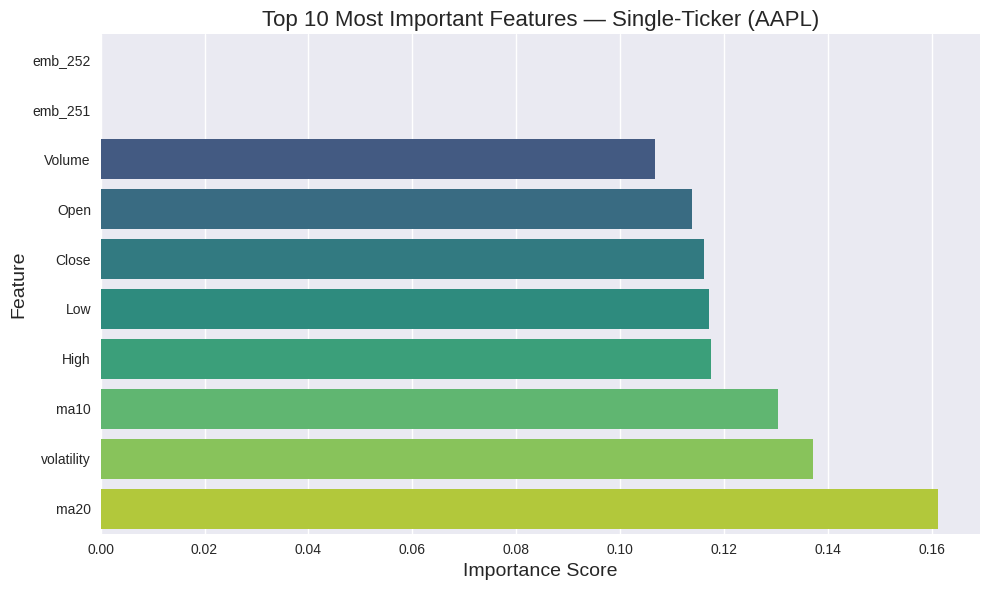

In [ ]:
imp_df = pd.DataFrame({
    "feature": feature_cols,
    "importance": importances
}).sort_values("importance", ascending=False)

topN = 10
top10 = imp_df.head(topN)

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top10[::-1],
    x="importance",
    y="feature",
    palette="viridis"
)
plt.title("Top 10 Most Important Features — Single-Ticker (AAPL)", fontsize=16)
plt.xlabel("Importance Score", fontsize=14)
plt.ylabel("Feature", fontsize=14)
plt.tight_layout()
plt.show()